In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from matplotlib.colors import LinearSegmentedColormap

pd.set_option('display.max_columns', None)


In [2]:
incident1 = pd.read_csv("./../../Data/original/Incident_2009-2017.csv", dtype={'IncidentNumber': 'str'}, low_memory=False)
incident2 = pd.read_excel("./../../Data/original/Incident_2018-2024.xlsx", dtype={'IncidentNumber': 'str'})

mob1 = pd.read_excel("./../../Data/original/Mobilisation_2009-2014.xlsx")
mob2 = pd.read_excel("./../../Data/original/Mobilisation_2015-2020.xlsx")
mob3 = pd.read_excel("./../../Data/original/Mobilisation_2021-2024.xlsx")

In [53]:
incidents = pd.concat([incident1, incident2], axis = 0)

In [54]:
incidents.index = incidents['IncidentNumber']

In [56]:
incidents = incidents.drop(['IncidentNumber'], axis = 1)

In [57]:
incidents_preview = pd.concat([incidents.head(10), incidents.tail(10)])
incidents_preview.to_csv('incidents_prev.csv')

In [55]:
incidents.head()

,IncidentNumber,DateTimeCall,DeployedFromStation_Name,DeployedFromLocation,PlusCode_Description,IncidentGroup,StopCodeDescription,PropertyCategory,Postcode_district,IncGeo_BoroughName,...,Latitude,Longitude,FRS,FirstPumpArriving_AttendanceTime,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,PumpCount,PumpMinutesRounded,Notional Cost (£),NumCalls
IncidentNumber,,,,,,,,,,,,,,,,,,,,,
235138081,235138081,2009-01-01 00:02:27,Battersea,0.0,Initial Mobilisation,Special Service,Special Service,Road Vehicle,SW11,WANDSWORTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2091,2091,2009-01-01 00:04:09,Edmonton,0.0,Initial Mobilisation,Fire,Secondary Fire,Outdoor,N9,ENFIELD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3091,3091,2009-01-01 00:04:57,Hillingdon,0.0,Initial Mobilisation,Fire,Secondary Fire,Outdoor,UB10,HILLINGDON,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5091,5091,2009-01-01 00:06:04,Holloway,0.0,Initial Mobilisation,Fire,Secondary Fire,Outdoor,N7,ISLINGTON,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6091,6091,2009-01-01 00:06:30,Kentish Town,0.0,Initial Mobilisation,False Alarm,AFA,Dwelling,NW5,CAMDEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
dfs = [mob1, mob2, mob3]

# Filter out invalid DataFrames and remove all-NA columns from each DataFrame
valid_dfs = []
for df in dfs:
    if not df.empty:  # Ensure the DataFrame is not empty
        # Drop all-NA columns
        df = df.dropna(axis=1, how='all')
        if not df.isna().all().all():  # Ensure the DataFrame is not all-NA after column removal
            valid_dfs.append(df)

# Concatenate the filtered DataFrames
mobilisation = pd.concat(valid_dfs, axis=0)

In [19]:
mobilisation.index = mobilisation['IncidentNumber']

In [51]:
mobilisation_preview = pd.concat([mobilisation.head(10), mobilisation.tail(10)])
mobilisation_preview.to_csv('mob_prev.csv')

In [22]:
# Convert 'DateOfCall' to datetime in incidents
incidents['DateOfCall'] = pd.to_datetime(incidents['DateOfCall'], format='%d-%b-%y')


In [10]:
data = pd.read_parquet('../data/dataframe_compressed.parquet')

In [11]:
columns_to_drop = [col for col in data.columns if 'CellEastingNorthing' in col and 'CellEastingNorthing2500' not in col]

# Drop the identified columns
data.drop(columns=columns_to_drop, inplace=True)
data

,DateTimeCall,TotalResponseTime,DistanceStation,IncidentGroup_Fire,IncidentGroup_Special Service,StopCodeDescription_Chimney Fire,StopCodeDescription_False alarm - Good intent,StopCodeDescription_False alarm - Malicious,StopCodeDescription_Late Call,StopCodeDescription_Primary Fire,StopCodeDescription_Secondary Fire,StopCodeDescription_Special Service,StopCodeDescription_Use of Special Operations Room,AggregatedPropertyCategory_Outdoor,AggregatedPropertyCategory_Residential,AggregatedPropertyCategory_Vehicle,CellEastingNorthing2500_502500-175000,CellEastingNorthing2500_502500-177500,CellEastingNorthing2500_502500-180000,CellEastingNorthing2500_502500-182500,CellEastingNorthing2500_502500-187500,CellEastingNorthing2500_502500-190000,CellEastingNorthing2500_502500-192500,CellEastingNorthing2500_505000-172500,CellEastingNorthing2500_505000-175000,CellEastingNorthing2500_505000-177500,CellEastingNorthing2500_505000-180000,CellEastingNorthing2500_505000-182500,CellEastingNorthing2500_505000-185000,CellEastingNorthing2500_505000-187500,CellEastingNorthing2500_505000-190000,CellEastingNorthing2500_507500-170000,CellEastingNorthing2500_507500-172500,CellEastingNorthing2500_507500-175000,CellEastingNorthing2500_507500-177500,CellEastingNorthing2500_507500-180000,CellEastingNorthing2500_507500-182500,CellEastingNorthing2500_507500-185000,CellEastingNorthing2500_507500-187500,CellEastingNorthing2500_507500-190000,CellEastingNorthing2500_510000-167500,CellEastingNorthing2500_510000-170000,CellEastingNorthing2500_510000-172500,CellEastingNorthing2500_510000-175000,CellEastingNorthing2500_510000-177500,CellEastingNorthing2500_510000-180000,CellEastingNorthing2500_510000-182500,CellEastingNorthing2500_510000-185000,CellEastingNorthing2500_510000-187500,CellEastingNorthing2500_510000-190000,CellEastingNorthing2500_512500-167500,CellEastingNorthing2500_512500-170000,CellEastingNorthing2500_512500-172500,CellEastingNorthing2500_512500-175000,CellEastingNorthing2500_512500-177500,CellEastingNorthing2500_512500-180000,CellEastingNorthing2500_512500-182500,CellEastingNorthing2500_512500-185000,CellEastingNorthing2500_512500-187500,CellEastingNorthing2500_512500-190000,CellEastingNorthing2500_512500-192500,CellEastingNorthing2500_515000-157500,CellEastingNorthing2500_515000-160000,CellEastingNorthing2500_515000-162500,CellEastingNorthing2500_515000-165000,CellEastingNorthing2500_515000-167500,CellEastingNorthing2500_515000-170000,CellEastingNorthing2500_515000-172500,CellEastingNorthing2500_515000-175000,CellEastingNorthing2500_515000-177500,CellEastingNorthing2500_515000-180000,CellEastingNorthing2500_515000-182500,CellEastingNorthing2500_515000-185000,CellEastingNorthing2500_515000-187500,CellEastingNorthing2500_515000-190000,CellEastingNorthing2500_515000-192500,CellEastingNorthing2500_517500-160000,CellEastingNorthing2500_517500-162500,CellEastingNorthing2500_517500-165000,CellEastingNorthing2500_517500-167500,CellEastingNorthing2500_517500-170000,CellEastingNorthing2500_517500-172500,CellEastingNorthing2500_517500-175000,CellEastingNorthing2500_517500-177500,CellEastingNorthing2500_517500-180000,CellEastingNorthing2500_517500-182500,CellEastingNorthing2500_517500-185000,CellEastingNorthing2500_517500-187500,CellEastingNorthing2500_517500-190000,CellEastingNorthing2500_517500-192500,CellEastingNorthing2500_517500-195000,CellEastingNorthing2500_520000-162500,CellEastingNorthing2500_520000-165000,CellEastingNorthing2500_520000-167500,CellEastingNorthing2500_520000-170000,CellEastingNorthing2500_520000-172500,CellEastingNorthing2500_520000-175000,CellEastingNorthing2500_520000-177500,CellEastingNorthing2500_520000-180000,CellEastingNorthing2500_520000-182500,CellEastingNorthing2500_520000-185000,CellEastingNorthing2500_520000-187500,CellEastingNorthing2500_520000-190000,CellEastingNorthing2500_520000-192500,CellEastingNorthing2500_520000-195000,CellEastingNorthing2500_522500-160000,CellEastingNorthing2500_522500-162500,CellEastingNorthing2500_5225

In [65]:
filtered_columns = [col for col in df.columns if 'CellEastingNorthing' not in col]

# Print the filtered column names
print(filtered_columns)

['IncidentGroup_Fire', 'IncidentGroup_Special Service', 'AggregatedPropertyCategory_Outdoor', 'AggregatedPropertyCategory_Residential', 'AggregatedPropertyCategory_Vehicle', 'IsBankholiday', 'IsWeekend', 'DistanceStationLog', 'TotalResponseTimeLog', 'Hour_sin', 'Hour_cos', 'Weekday_sin', 'Weekday_cos', 'Month_sin', 'Month_cos']


In [67]:
df_without_geo = df[filtered_columns]

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_without_geo, df_without_geo['TotalResponseTimeLog'], test_size=0.2)

In [77]:
X_test.to_parquet('df_no_geo.parquet')

In [78]:
X_test.columns

Index(['IncidentGroup_Fire', 'IncidentGroup_Special Service',
       'AggregatedPropertyCategory_Outdoor',
       'AggregatedPropertyCategory_Residential',
       'AggregatedPropertyCategory_Vehicle', 'IsBankholiday', 'IsWeekend',
       'DistanceStationLog', 'TotalResponseTimeLog', 'Hour_sin', 'Hour_cos',
       'Weekday_sin', 'Weekday_cos', 'Month_sin', 'Month_cos'],
      dtype='object')

In [68]:
df_without_geo.to_parquet('df_no_geo.parquet')

In [79]:
#df_preview = pd.concat([df.head(10), df.tail(10)])
df_without_geo.to_parquet('df_no_geo.parquet')

In [60]:
combined_df.head()

,IncidentNumber,DateOfCall,CalYear_x,TimeOfCall,HourOfCall_x,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,...,DateAndTimeLeft,DateAndTimeReturned,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,PlusCode_Code,PlusCode_Description,DelayCodeId,DelayCode_Description
0,235138081.00,2009-01-01,2009,00:00:37,0,Special Service,Special Service,RTC,Road Vehicle,Car,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1091.00,2009-01-01,2009,00:00:46,0,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2091.00,2009-01-01,2009,00:03:00,0,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3091.00,2009-01-01,2009,00:04:27,0,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5091.00,2009-01-01,2009,00:05:39,0,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
combined_df = combined_df.loc[combined_df.PumpOrder == 1].copy()

In [3]:
data = pd.read_parquet('../data/df_cleaned_for_classification_models.parquet')

In [9]:
data.columns

Index(['TotalResponseTime', 'CellEastingNorthing2500_502500-175000',
       'CellEastingNorthing2500_502500-177500',
       'CellEastingNorthing2500_502500-180000',
       'CellEastingNorthing2500_502500-182500',
       'CellEastingNorthing2500_502500-187500',
       'CellEastingNorthing2500_502500-190000',
       'CellEastingNorthing2500_502500-192500',
       'CellEastingNorthing2500_505000-172500',
       'CellEastingNorthing2500_505000-175000',
       ...
       'CellEastingNorthing2500_555000-182500',
       'CellEastingNorthing2500_555000-185000',
       'CellEastingNorthing2500_555000-187500',
       'CellEastingNorthing2500_555000-190000',
       'CellEastingNorthing2500_555000-192500',
       'CellEastingNorthing2500_557500-182500',
       'CellEastingNorthing2500_557500-185000',
       'CellEastingNorthing2500_557500-187500',
       'CellEastingNorthing2500_560000-185000',
       'CellEastingNorthing2500_560000-187500'],
      dtype='object', length=306)

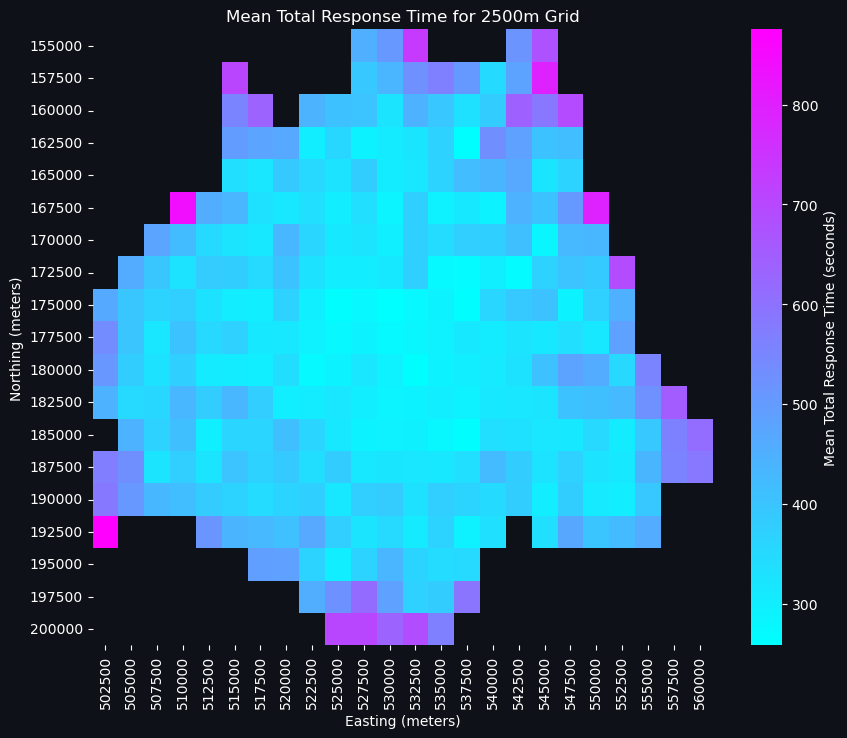

In [8]:
columns_to_keep = ['TotalResponseTime'] + [col for col in data.columns if col.startswith('CellEastingNorthing2500_')]
data = data[columns_to_keep]

# Ensure the target variable is in floating point format
data['TotalResponseTime'] = data['TotalResponseTime'].astype('float32')

# Function to process data
def process_data(data):
    cell_columns = [col for col in data.columns if col.startswith('CellEastingNorthing2500_')]
    target = 'TotalResponseTime'
    
    # Melt the dataframe to have a long format for cell columns
    melted_data = data.melt(id_vars=[target], value_vars=cell_columns, var_name='Cell', value_name='Value')
    
    # Filter out rows where Value is 0 (not in the cell)
    filtered_data = melted_data[melted_data['Value'] == 1]
    
    # Calculate mean response time for each cell
    mean_response_time = filtered_data.groupby('Cell')[target].mean().reset_index()
    
    return mean_response_time

# Process the data
mean_response_time = process_data(data)

# Extract easting and northing from cell names
mean_response_time['Easting'] = mean_response_time['Cell'].apply(lambda x: int(x.split('_')[1].split('-')[0]))
mean_response_time['Northing'] = mean_response_time['Cell'].apply(lambda x: int(x.split('_')[1].split('-')[1]))

# Pivot the table to create a grid format
heatmap_data = mean_response_time.pivot(index='Northing', columns='Easting', values='TotalResponseTime')

# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#00FFFF", "#FF00FF"])

# Set the style for the plot
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap with the custom style
sns.heatmap(heatmap_data, cmap=custom_cmap, cbar_kws={'label': 'Mean Total Response Time (seconds)'}, edgecolor='none', ax=ax)

# Set the facecolor for the figure and the axes
fig.patch.set_facecolor('#0E1117')
ax.set_facecolor('#0E1117')

# Customize the title and labels
ax.set_title('Mean Total Response Time for 2500m Grid', color='white')
ax.set_xlabel('Easting (meters)', color='white')
ax.set_ylabel('Northing (meters)', color='white')

# Customize the tick parameters
ax.tick_params(colors='white')

# Adjust the colorbar to match the background color
cbar = ax.collections[0].colorbar
cbar.ax.set_facecolor('#0E1117')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

# Save the figure
plt.savefig('/users/Isi/anaconda3/envs/FireBrigade/MAY24_BDS_INT_Fire_Brigade/img/mean_total_response_time_heatmap_beforebinary.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

C:\Users\Isi\AppData\Local\Temp\ipykernel_9648\367484286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year'] = pd.DatetimeIndex(data['DateTimeCall']).year
C:\Users\Isi\anaconda3\envs\FireBrigade\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Isi\anaconda3\envs\FireBrigade\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


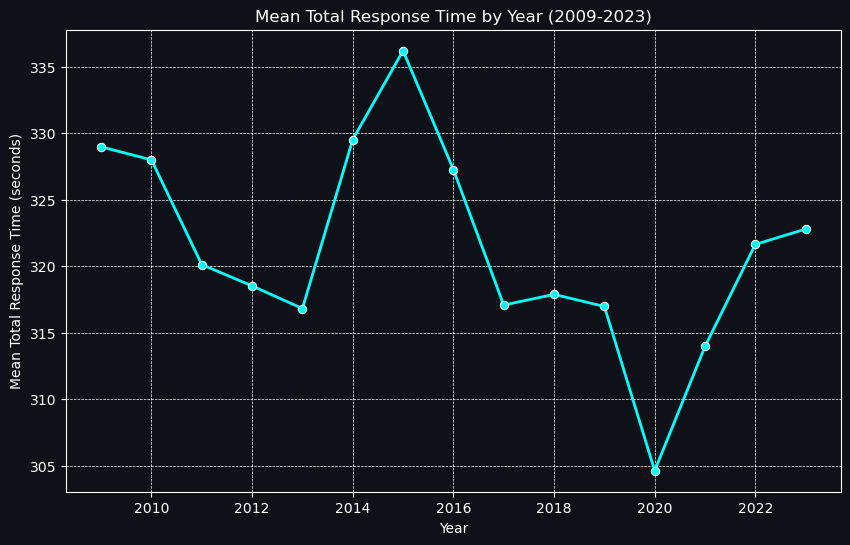

In [13]:
data['Year'] = pd.DatetimeIndex(data['DateTimeCall']).year

# Filter data to include only the years 2009-2023
data = data[data['Year'].between(2009, 2023)]

# Group by year and calculate the mean total response time
mean_response_time_by_year = data.groupby('Year')['TotalResponseTime'].mean().reset_index()

# Set the style for the plot
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the line plot with the custom style
sns.lineplot(data=mean_response_time_by_year, x='Year', y='TotalResponseTime', marker='o', color='#00FFFF', linewidth=2, ax=ax)

# Customize the title and labels
ax.set_title('Mean Total Response Time by Year (2009-2023)', color='white')
ax.set_xlabel('Year', color='white')
ax.set_ylabel('Mean Total Response Time (seconds)', color='white')

# Customize the tick parameters
ax.tick_params(colors='white')

# Set the facecolor for the figure and the axes
fig.patch.set_facecolor('#0E1117')
ax.set_facecolor('#0E1117')
ax.grid(True, color='white', linestyle='--', linewidth=0.5)

# Save the figure
plt.savefig('/users/Isi/anaconda3/envs/FireBrigade/MAY24_BDS_INT_Fire_Brigade/img/mean_total_response_time_by_year.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

# Show the plot
plt.show()